In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
%matplotlib inline

In [2]:
#configuration section
batch_size     = 20
embedding_size = 2
num_sampled    = 15    # Number of negative examples to sample.

In [11]:
#data section
sentences = [
    "1.33GHz Intel Z3735F processor",
    "2GB DDR3 RAM",
    "32GB hard drive", 
    "Windows 10 operating system",
    "1.3kg laptop",
    "A sleek and lightweight design with a heavy-duty\
    11 hour battery backup and pre-installed Windows 10. The Intel Quad Core Processor (up to 1.83GHz)\
    along with the Dual Speakers and 29.46cm (11.6) IPS display makes for a delightful everyday computing experience.",
    "All new 2017 Apple MacBook Air\
    1.8GHz Intel Core i5 processor\
    8GB LPDDR3 RAM, 128GB Solid State hard drive\
    13.3-inch screen, Intel HD Graphics 6000\
    MacOS Sierra operating system\
    1.35kg laptop\
    1440x900 pixels per inch with support for millions of colors, 720p FaceTime HD camera\
    1 year warranty from manufacturer from date of purchase"
]
# print(sentences)
words = " ".join(sentences).split()
# print(words)
#get the most common words i.e. list of (word, count)
count = collections.Counter(words).most_common()
print(len(count))
revDictionary = [i[0] for i in count]
#word->id dictionary
dictionary = {i[0]:index for index, i in enumerate(count)}
voc_size = len(dictionary)
#make indexed data for data in corpus
data = [dictionary[word] for word in words]
print("Samole data")
print(data[:10])
print([revDictionary[item] for item in data[:10]])

91
Samole data
[80, 0, 58, 8, 63, 45, 21, 64, 4, 15]
['1.33GHz', 'Intel', 'Z3735F', 'processor', '2GB', 'DDR3', 'RAM', '32GB', 'hard', 'drive']


In [17]:
#create cbow pairs
cbow_pairs = []
for index in range(1, len(data)-1):
    cbow_pairs.append([[data[index-1], data[index+1]], data[index]])
print(cbow_pairs[:10])

[[[80, 58], 0], [[0, 8], 58], [[58, 63], 8], [[8, 45], 63], [[63, 21], 45], [[45, 64], 21], [[21, 4], 64], [[64, 15], 4], [[4, 13], 15], [[15, 24], 13]]


In [18]:
#create skip gram pairs
skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
print('skip-gram pairs', skip_gram_pairs[:5])


('skip-gram pairs', [[0, 80], [0, 58], [58, 0], [58, 8], [8, 58]])


In [19]:
#generate training set
def generate_batch(size):
    x_data = []
    y_data = []
    #replace for whether the sample is with or without replacement
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

In [21]:
#creating the placeholders pipeline
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
#create embedding variable of size [CLASS X DIMENSION]
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
#create lookup variable
embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table
        


In [22]:
#create nce weights
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

In [23]:
#construct nce loss
# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, labels, inputss, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
#Takes the following:
#1. wts:- numClasses X dimension, bias:- numberOfClasses
#3. labels:-[batch, numTrye], input:- [Batch X dimension]
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, voc_size))
# Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

('Loss at ', 0, 21.124479)
('Loss at ', 10, 23.192398)
('Loss at ', 20, 14.743945)
('Loss at ', 30, 6.0520511)
('Loss at ', 40, 7.0778017)
('Loss at ', 50, 4.0993586)
('Loss at ', 60, 5.3540182)
('Loss at ', 70, 4.4170599)
('Loss at ', 80, 3.5613995)
('Loss at ', 90, 3.3660469)


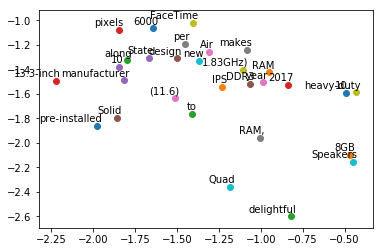

In [28]:
# Launch the graph in a session
with tf.Session() as sess:
    # Initializing all variables
    tf.global_variables_initializer().run()
    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        if step % 10 == 0:
            print("Loss at ", step, loss_val) # Report the loss
    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()
    # Show word2vec if dim is 2
    if trained_embeddings.shape[1] == 2:
        labels = revDictionary[20:50] # Show top 10 words
        for i, label in enumerate(labels):
            x, y = trained_embeddings[i,:]
            plt.scatter(x, y)
            plt.annotate(label, xy=(x, y), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom')
        plt.savefig("word2vec.png")